<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/asdasdasdasdasdasdasd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [173]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download("AAPL", start="2006-01-01", end="2022-01-01")

[*********************100%%**********************]  1 of 1 completed


In [174]:
#Distribution of the dataset
df_close = stock_data['Close']
df_log = np.log(df_close)

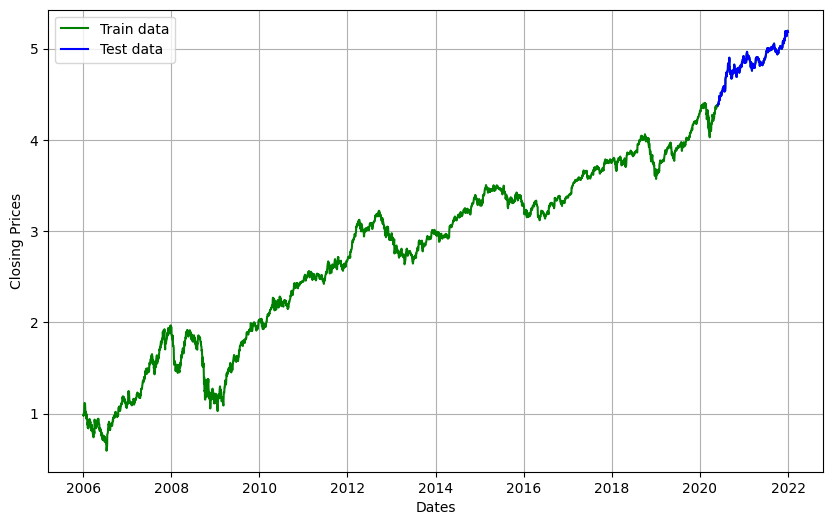

In [175]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [176]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17822.452, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17823.676, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17823.777, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17817.080, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17821.748, Time=3.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17822.493, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17812.487, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17817.940, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 8.257 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3622
Model:               SARIMAX(0, 1, 1)   Log Likelihood                8914.888
Date:                Tue, 12 Sep 2023   AIC                         -17823.777
Time:               

In [177]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3622
Model:                 ARIMA(0, 1, 1)   Log Likelihood                8910.970
Date:                Tue, 12 Sep 2023   AIC                         -17817.940
Time:                        21:30:42   BIC                         -17805.551
Sample:                             0   HQIC                        -17813.526
                               - 3622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0294      0.010     -2.948      0.003      -0.049      -0.010
sigma2         0.0004    4.8e-06     88.798      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

[*********************100%%**********************]  1 of 1 completed


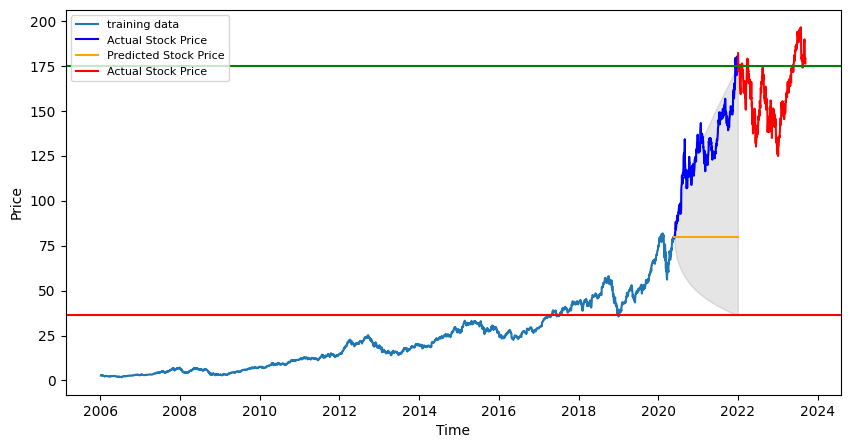

In [181]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

stock_data = yf.download("AAPL", start="2022-01-02", end="2023-09-13")
plt.plot(stock_data["Close"], color='red', label='Actual Stock Price')


plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [179]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.25227574581413376
MAE: 0.47373944407018176
RMSE: 0.5022705902341225
MAPE: 0.09657893533177522


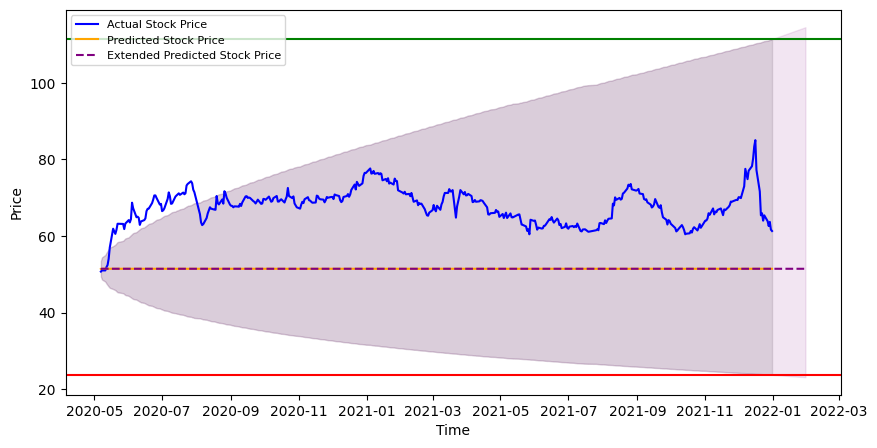

In [172]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Assuming you already have the forecast_results, fc, conf, fc_series, lower_series, and upper_series

# Extend the time horizon by 30 days
extended_steps = 30
forecast_extended = fitted.get_forecast(steps=len(test_data) + extended_steps, alpha=0.05)

# Extract the extended forecast and confidence intervals
fc_extended = forecast_extended.predicted_mean
conf_extended = forecast_extended.conf_int()

# Create Series for the extended forecast and confidence intervals
fc_series_extended = pd.Series(fc_extended, index=fc_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))
lower_series_extended = pd.Series(conf_extended.iloc[:, 0], index=lower_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))
upper_series_extended = pd.Series(conf_extended.iloc[:, 1], index=upper_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))

# Plot the extended forecast
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')
plt.plot(fc_series_extended.index, np.exp(fc_extended), color='purple', linestyle='--', label='Extended Predicted Stock Price')  # Convert back to original scale

# Fill the area between the confidence intervals
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]), color='k', alpha=.10)
plt.fill_between(fc_series_extended.index, np.exp(conf_extended.iloc[:, 0]), np.exp(conf_extended.iloc[:, 1]), color='purple', alpha=.10)

# Add horizontal lines for the maximum and minimum bounds of the confidence intervals
plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
